自测：1.第一次答题20题，花费2min42s。2.第二次答不同的测试题21题，花费2min32s。3.第三次答不同的测试题21题，花费2min33s  
答题状态（理想）：在已知会计时的情况下，答题质量为主，不浪费时间为辅，平稳答题。  
测试结果：  
1.理想答题状态下，健康人25-27min完成200题，37-40min完成300题。可作为判断时间长短的参考标的  
2.有过类似答题经验会加快思考速度，缩短答题时间；

# 爬取服务器数据到本地存储

In [1]:
# 在老师提供的网址上爬取数据
import requests
import os
r = requests.get('http://yang.lzu.edu.cn/data/index.txt')

In [2]:
# 爬取数据的处理
content = r.text.splitlines(False) # 按换行符分割成不同子路径
paths = []
file_path = r'E:\code\data\DSP_data4.9' # 爬取数据的本地存储路径
for path in content: # 去掉开头的‘./’,保留完整文件路径的字符串,文件夹路径用来创建本地文件夹
    path = path.lstrip('./')
    if path.endswith("json"): 
        paths.append(path)
    else: 
        os.makedirs(os.path.join(file_path,path)) # https://www.cnblogs.com/MisterZhang/p/9134709.html os.mkdir和os.mkdirs

FileExistsError: [WinError 183] 当文件已存在时，无法创建该文件。: 'E:\\code\\data\\DSP_data4.9\\accelerometer/anxiety/female'

In [ ]:
urls = list(map(lambda x: r'http://yang.lzu.edu.cn/data/'+x,paths)) # 获取完整爬取资源的url
url_files = dict(zip(urls,paths))
for url , path in url_files.items(): # 访问资源并下载
    try:
        r = requests.get(url)
    except:
        print('访问失败,file_name未保存')
    with open(os.path.join(file_path,path),'w') as f:
        f.write(r.text)
        f.close()
        print(path.split('/')[-1]+'已保存')
print('已完成')

有监督二元分类问题（health or anxiety）

# data cleaning(1)

处理空文件和有空值文件

## process empty files and missing values

In [4]:
# 导入常用库
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [5]:
# 导入本地存储数据的文件夹路径
path_acc_anx = r'E:\code\data\DSP_data4.9\accelerometer\anxiety\female'
path_acc_hea = r'E:\code\data\DSP_data4.9\accelerometer\health\female'
path_dev_anx = r'E:\code\data\DSP_data4.9\device_motion\anxiety\female'
path_dev_hea = r'E:\code\data\DSP_data4.9\device_motion\health\female'
path_gyr_anx = r'E:\code\data\DSP_data4.9\gyroscope\anxiety\female'
path_gyr_hea = r'E:\code\data\DSP_data4.9\gyroscope\health\female'

In [6]:
def empty_process(directory): # returns a list of files that are not empty files in the specified folder
    files = os.listdir(directory)
    new_files = []
    for file in files:
        try:
            data = pd.read_json(os.path.join(directory,file))
        except:
            print(file+'文件打开时报错') # 爬取数据时可能出问题，导致爬取的文件数据不完整，导致不是valid json，无法read_json打开文件
        if data.empty:
            print(os.path.join(directory,file)+'文件是空的')
        elif data.isnull().any().sum() > 0:
            print(os.path.join(directory,file)+'文件有空值')
        else:
            new_files.append(file)
    print('已完成')
    return new_files

In [7]:
files_acc_anx = empty_process(path_acc_anx)
files_acc_hea = empty_process(path_acc_hea)
files_dev_anx = empty_process(path_dev_anx)
files_dev_hea = empty_process(path_dev_hea)
files_gyr_anx = empty_process(path_gyr_anx)
files_gyr_hea = empty_process(path_gyr_hea)

已完成
已完成
已完成
已完成
E:\code\data\DSP_data4.9\gyroscope\anxiety\female\20191114161025_2943_gyroscope.json文件是空的
E:\code\data\DSP_data4.9\gyroscope\anxiety\female\20191114171226_3006_gyroscope.json文件是空的
E:\code\data\DSP_data4.9\gyroscope\anxiety\female\20191116154726_3651_gyroscope.json文件是空的
E:\code\data\DSP_data4.9\gyroscope\anxiety\female\20191118173012_3937_gyroscope.json文件是空的
已完成
E:\code\data\DSP_data4.9\gyroscope\health\female\20191111111559_1665_gyroscope.json文件是空的
已完成


In [8]:
print(
    '20191114161025_2943_gyroscope.json' in files_gyr_anx,
    '20191118173012_3937_gyroscope.json' in files_gyr_anx,
    '20191114171226_3006_gyroscope.json' in files_gyr_anx,
    '20191116154726_3651_gyroscope.json' in files_gyr_anx,
    '20191111111559_1665_gyroscope.json' in files_gyr_hea)

False False False False False


# data integration

In [9]:
def files_to_framework(path,files): # 以数据description特征为每个人记录的特征
    data_file = pd.read_json(os.path.join(path,files[0]))
    data_dsc = data_file.describe().T
    data_l = data_dsc.iloc[0].rename(lambda x:x+'_x')
    data_m = data_dsc.iloc[1].rename(lambda x:x+'_y')
    data_r = data_dsc.iloc[2].rename(lambda x:x+'_z')
    data_all = pd.concat([data_l,data_m,data_r]).to_frame().T
    for file in files[1:]:
        data_file = pd.read_json(os.path.join(path,file))
        data_dsc = data_file.describe().T
        data_l = data_dsc.iloc[0].rename(lambda x:x+'_x') # https://blog.csdn.net/weixin_44056331/article/details/89460559 dataframe 和 series换索引
        data_m = data_dsc.iloc[1].rename(lambda x:x+'_y')
        data_r = data_dsc.iloc[2].rename(lambda x:x+'_z')
        data_file = pd.concat([data_l,data_m,data_r]).to_frame().T
        data_all = data_all.append(data_file, ignore_index=True)
    return data_all

In [10]:
# 把文件夹里的多个文件转化为一个dataframe
pd_acc_anx = files_to_framework(path_acc_anx,files_acc_anx)
pd_acc_hea = files_to_framework(path_acc_hea,files_acc_hea)
pd_dev_anx = files_to_framework(path_dev_anx,files_dev_anx)
pd_dev_hea = files_to_framework(path_dev_hea,files_dev_hea)
pd_gyr_anx = files_to_framework(path_gyr_anx,files_gyr_anx)
pd_gyr_hea = files_to_framework(path_gyr_hea,files_gyr_hea)

In [11]:
# 增加是否患病'ill'特征
pd_acc_anx['ill'] = [1 for i in range(len(pd_acc_anx))]
pd_acc_hea['ill'] = [0 for i in range(len(pd_acc_hea))]
pd_dev_anx['ill'] = [1 for i in range(len(pd_dev_anx))]
pd_dev_hea['ill'] = [0 for i in range(len(pd_dev_hea))]
pd_gyr_anx['ill'] = [1 for i in range(len(pd_gyr_anx))]
pd_gyr_hea['ill'] = [0 for i in range(len(pd_gyr_hea))]

In [12]:
# 将同一个传感器，不同分类的记录合并在一起
pd_acc = pd.concat([pd_acc_anx, pd_acc_hea],sort=False, ignore_index = True)
pd_dev = pd.concat([pd_dev_anx, pd_dev_hea],sort=False, ignore_index = True)
pd_gyr = pd.concat([pd_gyr_anx, pd_gyr_hea],sort=False, ignore_index = True)

In [13]:
pd_acc.describe()

,count_x,mean_x,std_x,min_x,25%_x,50%_x,75%_x,max_x,count_y,mean_y,...,max_y,count_z,mean_z,std_z,min_z,25%_z,50%_z,75%_z,max_z,ill
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,...,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,7724.217949,0.038414,0.095294,-0.610379,-0.010279,0.037034,0.089292,0.702717,7724.217949,-0.470446,...,0.213956,7724.217949,-0.812632,0.089912,-1.393896,-0.870323,-0.823790,-0.766103,-0.086634,0.474359
std,6928.183847,0.083926,0.042629,0.373014,0.087337,0.085739,0.091064,0.455189,6928.183847,0.167786,...,0.479584,6928.183847,0.111697,0.054567,0.369816,0.094187,0.123144,0.146072,0.627495,0.502574
min,1871.000000,-0.224102,0.031024,-1.887728,-0.284193,-0.216853,-0.184463,0.165721,1871.000000,-0.915620,...,-0.493541,1871.000000,-0.977261,0.019312,-3.138536,-0.987563,-0.987335,-0.987132,-0.740145,0.000000
25%,4113.000000,-0.011228,0.061828,-0.756438,-0.052501,-0.018211,0.025522,0.435261,4113.000000,-0.578896,...,-0.060792,4113.000000,-0.879117,0.051622,-1.597074,-0.942910,-0.908634,-0.860834,-0.467326,0.000000
50%,4826.500000,0.045931,0.087707,-0.537868,0.010997,0.050794,0.086545,0.629073,4826.500000,-0.483457,...,0.129370,4826.500000,-0.837453,0.074784,-1.298589,-0.891911,-0.842386,-0.806505,-0.308855,0.000000
75%,6569.250000,0.091744,0.122416,-0.370843,0.040551,0.083745,0.139672,0.844727,6569.250000,-0.381578,...,0.398376,6569.250000,-0.774027,0.111587,-1.126667,-0.822871,-0.772915,-0.711276,0.008187,1.000000
max,32928.000000,0.236153,0.189282,-0.107260,0.185559,0.239388,0.290871,2.844711,32928.000000,-0.012923,...,2.345360,32928.000000,-0.275947,0.289505,-0.880388,-0.531157,-0.201466,-0.146580,2.652325,1.000000


In [14]:
# 毋庸置疑，同一个样本xyz轴记录数count一样，所以去掉count_y,count_z
# 25%75%四分位数特征可以通过EDA的可视化看分布情况，所以去掉
pd_acc = pd_acc.drop(['count_y','count_z','25%_x','75%_x','25%_y','75%_y','25%_z','75%_z'],axis = 1)
pd_dev = pd_dev.drop(['count_y','count_z','25%_x','75%_x','25%_y','75%_y','25%_z','75%_z'],axis = 1)
pd_gyr = pd_gyr.drop(['count_y','count_z','25%_x','75%_x','25%_y','75%_y','25%_z','75%_z'],axis = 1)

In [15]:
pd_acc.rename(columns = {'count_x':'time'},inplace = True)
pd_dev.rename(columns = {'count_x':'time'},inplace = True)
pd_gyr.rename(columns = {'count_x':'time'},inplace = True)

In [16]:
pd_acc['time'] = pd_acc['time'].apply(lambda x: x/(5.0*60.0)) # time单位转化为分钟
pd_dev['time'] = pd_dev['time'].apply(lambda x: x/(5.0*60.0)) # time单位转化为分钟
pd_gyr['time'] = pd_gyr['time'].apply(lambda x: x/(5.0*60.0)) # time单位转化为分钟

# EDA

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

## 特征相关性分析

##### device_motion

In [72]:
# 各特征与预测值相关性系数排序
cor_dev = pd_dev.corr()
cor_dev['ill'].apply(lambda x: abs(x)).sort_values(ascending = False)

ill       1.000000
max_y     0.236883
min_y     0.175929
50%_y     0.134889
50%_x     0.122421
mean_y    0.117944
std_y     0.085025
50%_z     0.074572
mean_x    0.068042
std_x     0.063172
mean_z    0.061203
max_x     0.059241
min_z     0.057996
std_z     0.048150
max_z     0.025129
time      0.011364
min_x     0.003855
Name: ill, dtype: float64

1.特征y对预测影响较高
2.max_z,std_z,time，min_x影响很小，考虑删去

In [73]:
cor_dev.applymap(lambda x: x if((x > 0.5) | (x < -0.5)) & (x!=1.0) else np.nan)

,time,mean_x,std_x,min_x,50%_x,max_x,mean_y,std_y,min_y,50%_y,max_y,mean_z,std_z,min_z,50%_z,max_z,ill
time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean_x,NaN,NaN,NaN,NaN,0.929627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std_x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min_x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%_x,NaN,0.929627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean_y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.601187,0.991207,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std_y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.510719,NaN,0.578041,NaN,NaN,NaN,NaN
min_y,NaN,NaN,NaN,NaN,NaN,NaN,0.601187,NaN,NaN,0.586744,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%_y,NaN,NaN,NaN,NaN,NaN,NaN,0.991207,NaN,0.586744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


y的central tendency之间相关系数很高
std_y与std_z相关性系数较高0.578041,
max_y与max_z相关性系数较高0.551100,
max_y与std_z相关性系数较高0.538641,

综上所述，y与z的max和std相关性高

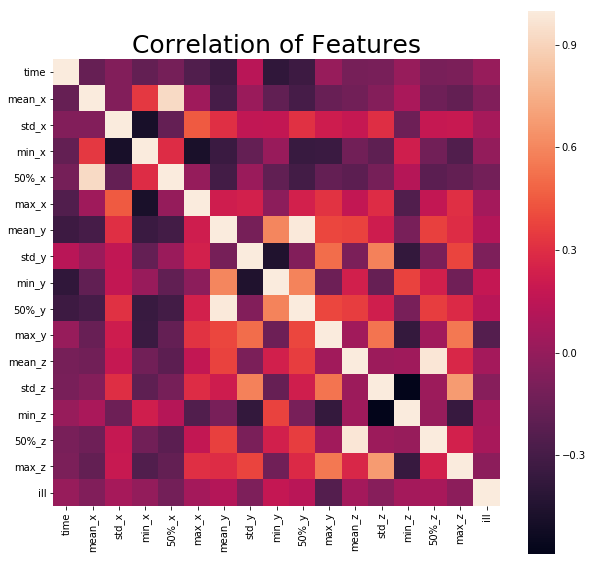

In [74]:
plt.subplots(figsize = (10, 10))
plt.title('Correlation of Features',size=25)
sns.heatmap(cor_dev,square = True)

##### accelerometer

In [75]:
# 各特征与预测值相关性系数排序
cor_acc = pd_acc.corr()
cor_acc['ill'].apply(lambda x: abs(x)).sort_values(ascending = False)

ill       1.000000
50%_y     0.177206
50%_z     0.161847
mean_y    0.155036
mean_z    0.147049
50%_x     0.119493
mean_x    0.116063
max_z     0.104233
min_z     0.088703
max_y     0.076834
std_x     0.075178
std_y     0.063697
max_x     0.048290
time      0.042509
min_x     0.029495
std_z     0.011321
min_y     0.009032
Name: ill, dtype: float64

1.特征y,z相关性系数较大
2.max_x,time,min_x,std_z,min_y相关性系数较小，考虑删去

In [77]:
cor_acc.applymap(lambda x: x if((x > 0.5) | (x < -0.5)) & (x!=1.0) else np.nan)

,time,mean_x,std_x,min_x,50%_x,max_x,mean_y,std_y,min_y,50%_y,max_y,mean_z,std_z,min_z,50%_z,max_z,ill
time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean_x,NaN,NaN,NaN,NaN,0.981729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std_x,NaN,NaN,NaN,-0.622078,NaN,0.531015,NaN,0.582519,NaN,NaN,0.597356,NaN,0.597798,NaN,NaN,0.554162,NaN
min_x,NaN,NaN,-0.622078,NaN,NaN,-0.611553,NaN,NaN,0.598748,NaN,-0.727883,NaN,NaN,0.579658,NaN,-0.679721,NaN
50%_x,NaN,0.981729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_x,NaN,NaN,0.531015,-0.611553,NaN,NaN,NaN,NaN,-0.652822,NaN,0.710690,NaN,NaN,-0.604910,NaN,0.809351,NaN
mean_y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.976009,NaN,-0.884359,NaN,NaN,-0.878023,NaN,NaN
std_y,NaN,NaN,0.582519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.636614,NaN,0.842325,NaN,NaN,NaN,NaN
min_y,NaN,NaN,NaN,0.598748,NaN,-0.652822,NaN,NaN,NaN,NaN,NaN,NaN,-0.505024,0.516189,NaN,-0.661596,NaN
50%_y,NaN,NaN,NaN,NaN,NaN,NaN,0.976009,NaN,NaN,NaN,NaN,-0.854009,NaN,NaN,-0.892276,NaN,NaN


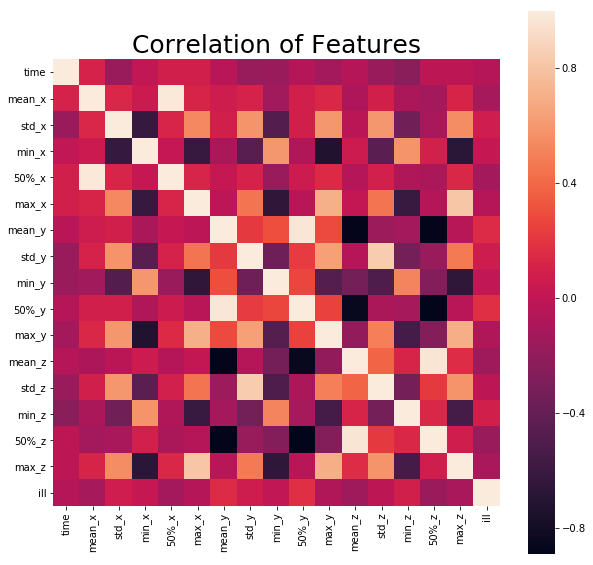

In [78]:
plt.subplots(figsize = (10, 10))
plt.title('Correlation of Features',size=25)
sns.heatmap(cor_acc,square = True)

##### gyroscope

In [79]:
# 各特征与预测值相关性系数排序
cor_gyr = pd_gyr.corr()
cor_gyr['ill'].apply(lambda x: abs(x)).sort_values(ascending = False)

ill       1.000000
50%_z     0.197789
50%_y     0.170942
mean_y    0.155264
time      0.140043
max_y     0.132588
std_x     0.128733
mean_x    0.115016
max_x     0.091429
min_x     0.072731
min_y     0.071882
50%_x     0.063372
std_y     0.062200
mean_z    0.060114
std_z     0.039629
min_z     0.029403
max_z     0.028375
Name: ill, dtype: float64

y,z的central tendency特征相关性系数较高，time特征终于看起来有用了
std_z,min_z,max_z特征相关性系数较低，考虑删去

In [81]:
cor_gyr.applymap(lambda x: x if((x > 0.5) | (x < -0.5)) & (x!=1.0) else np.nan)

,time,mean_x,std_x,min_x,50%_x,max_x,mean_y,std_y,min_y,50%_y,max_y,mean_z,std_z,min_z,50%_z,max_z,ill
time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean_x,NaN,NaN,NaN,NaN,0.959998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std_x,NaN,NaN,NaN,-0.840140,NaN,0.799662,NaN,0.897394,-0.520221,NaN,0.659244,NaN,0.862677,-0.759281,NaN,0.669342,NaN
min_x,NaN,NaN,-0.840140,NaN,NaN,-0.829747,NaN,-0.730322,NaN,NaN,-0.688021,NaN,-0.703464,0.613883,NaN,-0.576096,NaN
50%_x,NaN,0.959998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_x,NaN,NaN,0.799662,-0.829747,NaN,NaN,NaN,0.701312,NaN,NaN,0.574814,NaN,0.662188,-0.670818,NaN,0.644113,NaN
mean_y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.514549,NaN,0.950664,0.734700,NaN,NaN,-0.560111,NaN,NaN,NaN
std_y,NaN,NaN,0.897394,-0.730322,NaN,0.701312,0.514549,NaN,-0.785768,NaN,0.730881,NaN,0.902407,-0.835042,NaN,0.708628,NaN
min_y,NaN,NaN,-0.520221,NaN,NaN,NaN,NaN,-0.785768,NaN,NaN,-0.600481,NaN,-0.727566,0.736818,NaN,NaN,NaN
50%_y,NaN,NaN,NaN,NaN,NaN,NaN,0.950664,NaN,NaN,NaN,0.688873,NaN,NaN,-0.523046,NaN,NaN,NaN


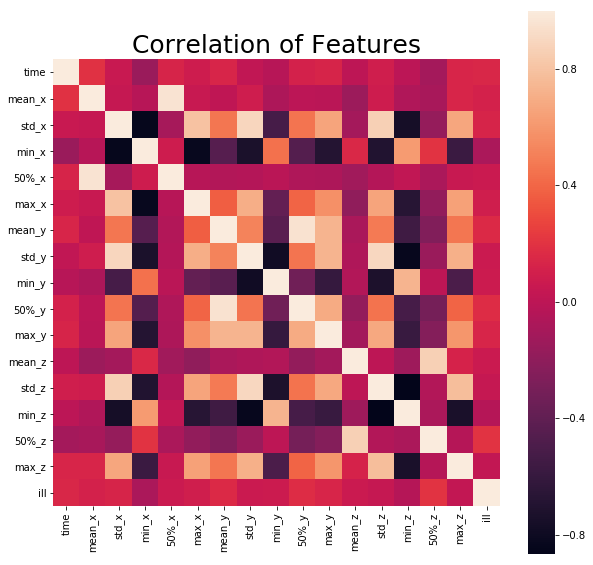

In [82]:
plt.subplots(figsize = (10, 10))
plt.title('Correlation of Features',size=25)
sns.heatmap(cor_gyr,square = True)

## EDA

In [20]:
def features_ill(framework,feature):
    facet = sns.FacetGrid(framework, hue="ill",aspect=2)
    facet.map(sns.kdeplot,feature,shade= True)#kdeplot核密度估计图，shade加阴影更容易看
    facet.set(xlim=(framework[feature].min(), framework[feature].max()))
    facet.add_legend()
    plt.xlabel(feature) 
    plt.ylabel('density') 
    plt.title(feature+'_ill')

### 查看健康人与病人时间分布

#### 时间和患病的关系

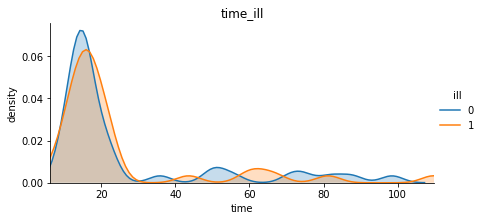

In [21]:
features_ill(pd_acc,'time')

    结论:绝大多数(70%)人的时间都在0-30min，少部分人时间平均在30-110min分布，病人和健康人时间差异不明显
    考虑情况可能是：
    1.题目答完了，设备还在记录；答题没答完，设备停止记录（不易通过现有数据验证，考虑直接询问研究是否严谨） 。
    2.时间在60min左右以答题质量为主认真答题
    3.少部分人做事拖拖拉拉或者乱答一气，属于噪声数据，考虑以线性回归拟合代替time特征60min以上记录的time特征

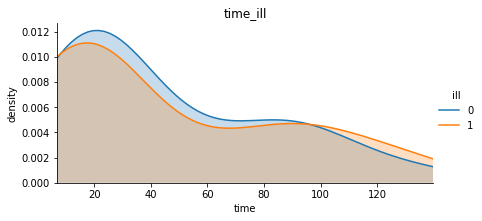

In [22]:
features_ill(pd_dev,'time')

结论：大部分分布在0-50min，少部分分布在50-110min
主观观点：这个看上去符合自测实验的结论，考虑以此为大体上的正常time特征分布

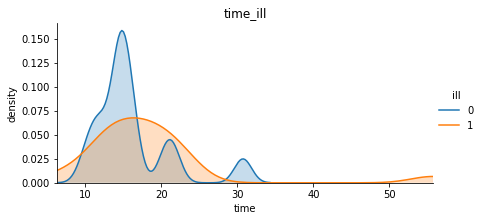

In [23]:
features_ill(pd_gyr,'time')

结论:主要分布在5-25min
50min以上的数据是离群点，但不一定是噪声

dev时间分布与acc、gyr明显不同，由于设备具体情况和实验具体情况不明，暂不清楚原因。
time特征与预测值相关性系数太小考虑删去，或者查验并处理时间特征离群点后再进行时间特征相关性分析看是否保留

### 查看xyz轴健康人与病人平均值分布

#### acc

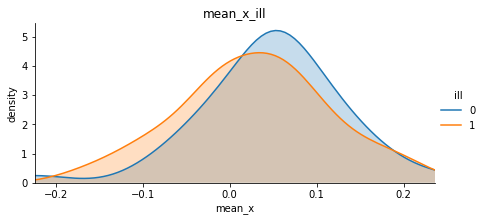

In [24]:
features_ill(pd_acc,'mean_x')

x轴平均值方面，健康的人比病人分布更易向x轴正方向

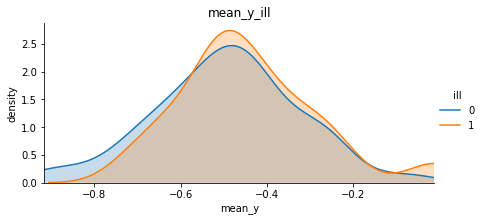

In [25]:
features_ill(pd_acc,'mean_y')

y轴平均值方面，健康的人比病人分布更易向x轴负方向

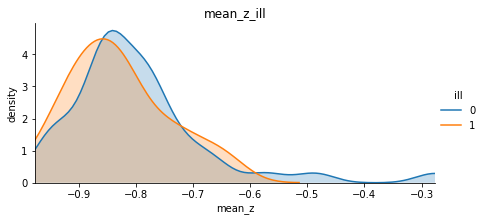

In [26]:
features_ill(pd_acc,'mean_z')

z轴平均值方面，健康的人比病人分布更易向x轴正方向

#### dev

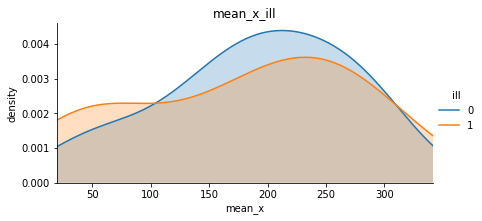

In [27]:
features_ill(pd_dev,'mean_x')

x轴平均值方面，健康的人比病人分布更易向x轴正方向

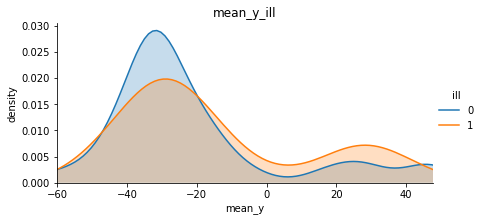

In [28]:
features_ill(pd_dev,'mean_y')

y轴平均值方面，健康的人比病人分布更易向x轴负方向

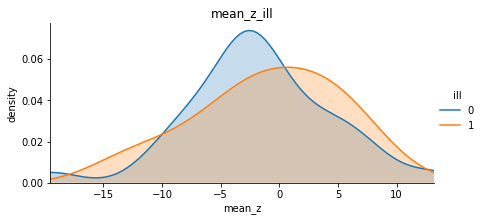

In [29]:
features_ill(pd_dev,'mean_z')

z轴平均值方面，健康的人比病人分布更易向z轴负方向

#### gyr

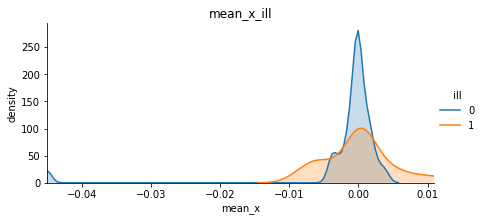

In [30]:
features_ill(pd_gyr,'mean_x')

x轴平均值方面，健康的人分布集中于-0.005~0.005之间，病人分布集中于-0.01~0.01之间，健康人分布峰度是病人峰度2倍有余

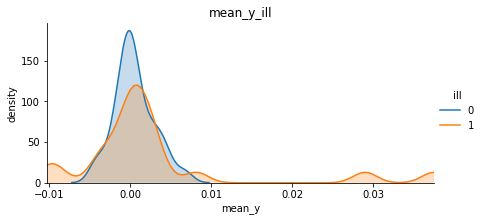

In [31]:
features_ill(pd_gyr,'mean_y')

y轴平均值方面，健康人和病人分布集中于-0.01~0.01之间，健康人分布峰度是病人峰度1.5倍左右

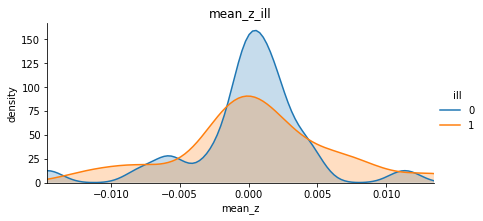

In [32]:
features_ill(pd_gyr,'mean_z')

z轴平均值方面，健康人和病人分布集中于-0.01~0.007之间，健康人分布峰度是病人峰度2倍左右

### xyz轴标准差和患病的关系

#### acc

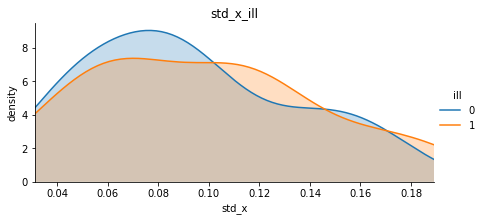

In [33]:
features_ill(pd_acc,'std_x')

x轴标准差方面，健康人和病人分布集中于0.03~0.18之间，健康的人比病人分布更易向x轴负方向

病人比健康人更易在x轴波动

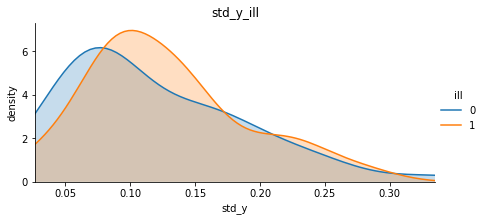

In [34]:
features_ill(pd_acc,'std_y')

y轴标准差方面，健康人和病人分布集中于0.03~0.25之间，病人比健康的人分布更易向x轴正方向

病人比健康人更易在y轴波动

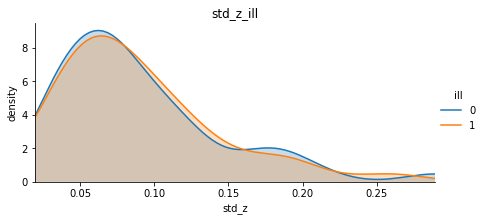

In [35]:
features_ill(pd_acc,'std_z')

z轴上二者很好地拟合，说明对患病与否关系关系不大，考虑删除该特征

#### dev

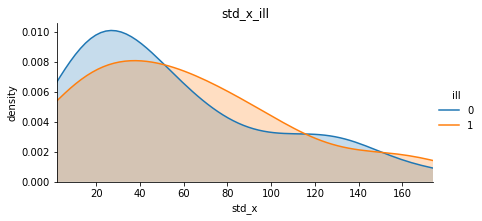

In [36]:
features_ill(pd_dev,'std_x')

x轴标准差方面，健康的人比病人分布更易向x轴负方向

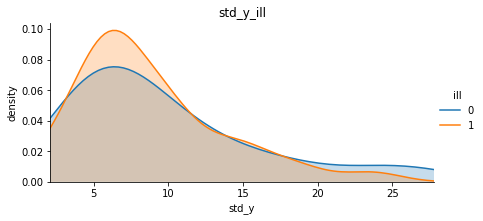

In [37]:
features_ill(pd_dev,'std_y')

y轴标准差方面，健康人和病人分布集中于0~15之间，病人是健康的人峰度1.3倍左右

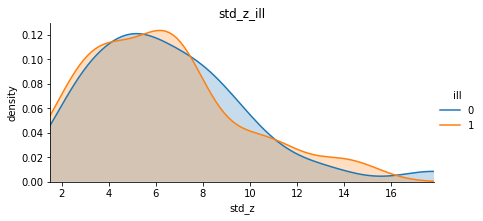

In [38]:
features_ill(pd_dev,'std_z')

二者拟合比较好，考虑删除该特征

#### gyr

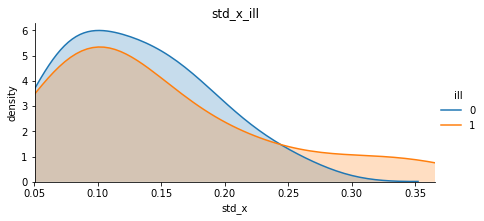

In [39]:
features_ill(pd_gyr,'std_x')

x轴标准差方面，健康的人比病人分布更易向x轴负方向

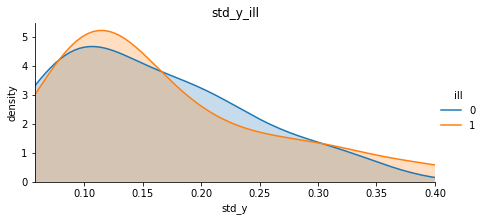

In [40]:
features_ill(pd_gyr,'std_y')

y轴标准差方面，病人比健康的人分布更易向y轴负方向

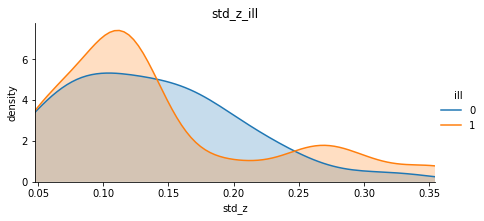

In [41]:
features_ill(pd_gyr,'std_z')

y轴标准差方面，大部分病人比健康的人分布更易向y轴负方向，小部分病人比健康的人分布更易向y轴正方向

### xyz轴中位数和患病的关系

#### acc

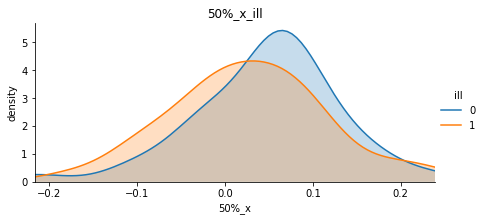

In [42]:
features_ill(pd_acc,'50%_x')

x轴中位数方面，病人比健康的人分布更易向x轴负方向

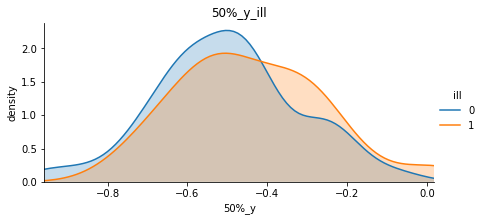

In [43]:
features_ill(pd_acc,'50%_y')

y轴中位数方面，病人比健康的人分布更易向x轴正方向

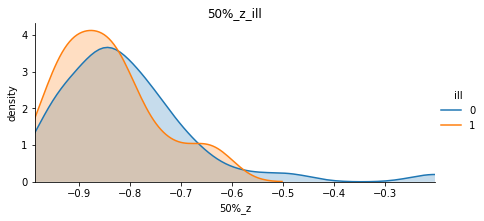

In [44]:
features_ill(pd_acc,'50%_z')

z轴中位数方面，病人比健康的人分布更易向z轴负方向

#### dev

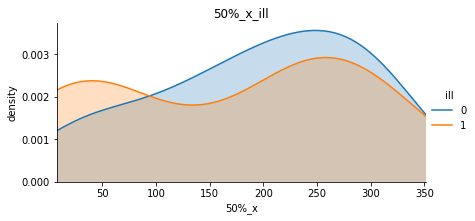

In [45]:
features_ill(pd_dev,'50%_x')

x轴中位数方面，健康的人比病人分布更易向x轴正方向

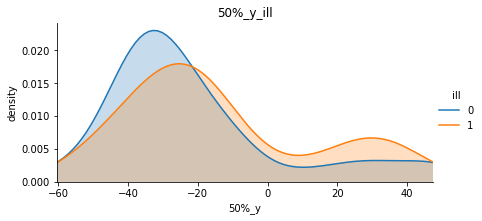

In [47]:
features_ill(pd_dev,'50%_y')

y轴中位数方面，健康的人比病人分布更易向y轴负方向

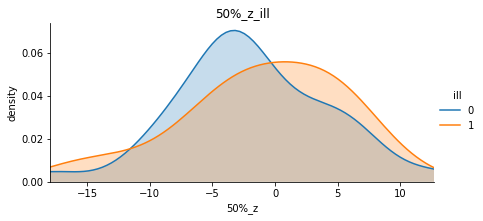

In [48]:
features_ill(pd_dev,'50%_z')

z轴中位数方面，健康的人比病人分布更易向z轴负方向

#### gyr

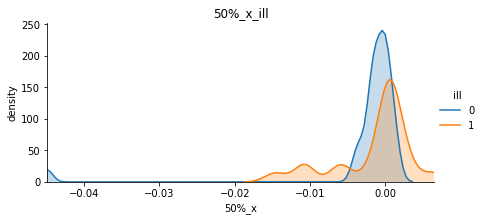

In [49]:
features_ill(pd_gyr,'50%_x')

x轴中位数方面，健康的人比病人分布峰值高1.5倍左右
健康人有离群点，考虑是噪声，取中位数代替该特征

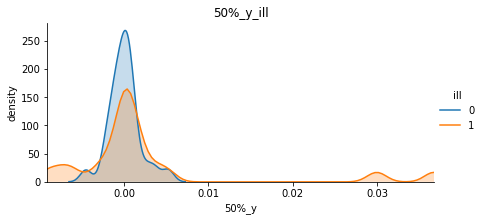

In [50]:
features_ill(pd_gyr,'50%_y')

y轴中位数方面，健康的人比病人分布峰值高1.7倍左右
病人有离群点，考虑是噪声，取中位数代替该特征

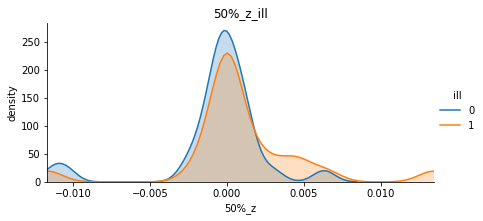

In [51]:
features_ill(pd_gyr,'50%_z')

z轴中位数方面，健康的人比病人分布拟合很好，考虑删除该特征

### y轴极值和患病的关系

#### acc

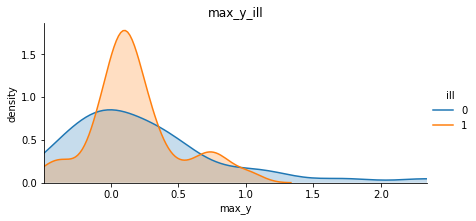

In [52]:
features_ill(pd_acc,'max_y')

y轴最大值方面，病人是健康的人分布峰值高2倍左右

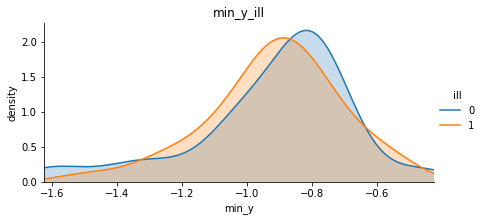

In [53]:
features_ill(pd_acc,'min_y')

拟合好，考虑删

#### dev

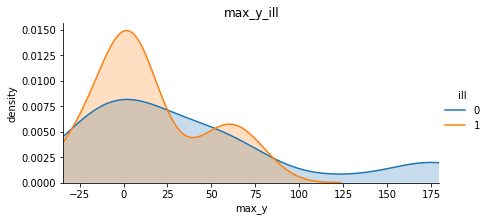

In [54]:
features_ill(pd_dev,'max_y')

y轴最大值方面，病人是健康的人分布峰值高2倍左右

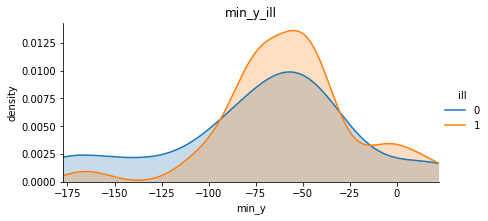

In [55]:
features_ill(pd_dev,'min_y')

y轴最小值方面，病人是健康的人分布峰值高1.4倍左右

#### gyr

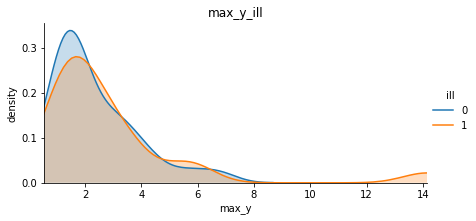

In [56]:
features_ill(pd_gyr,'max_y')

拟合好，考虑删

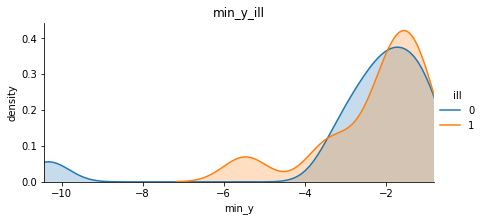

In [57]:
features_ill(pd_gyr,'min_y')

y轴最小值方面，大部分健康的人和病人分布拟合很好，但小部分属于离群点

### x轴最大值和患病的关系

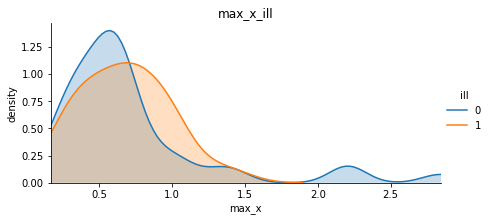

In [58]:
features_ill(pd_acc,'max_x')

x轴最大值方面，健康的人比病人分布更易向x轴负方向

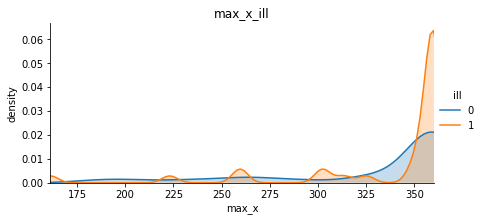

In [59]:
features_ill(pd_dev,'max_x')

x轴最大值方面，病人是健康的人分布峰值3倍左右

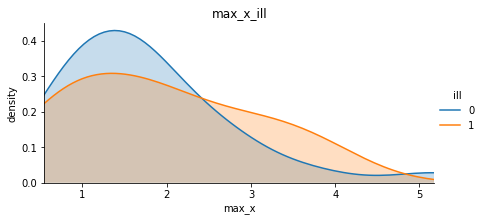

In [60]:
features_ill(pd_gyr,'max_x')

x轴最大值方面，健康的人比病人分布更易向x轴负方向

### z轴最小值和患病的关系

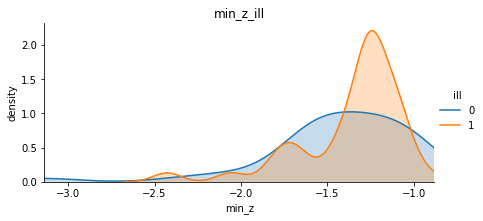

In [61]:
features_ill(pd_acc,'min_z')

z轴最小值方面，病人比健康的人分布更易向z轴正方向，病人是健康的人分布峰度2倍

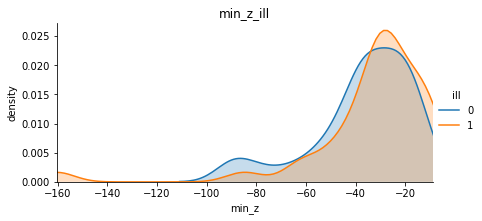

In [62]:
features_ill(pd_dev,'min_z')

拟合好，考虑删除该特征

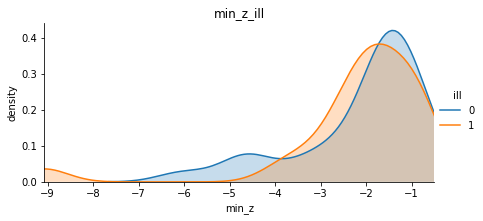

In [63]:
features_ill(pd_gyr,'min_z')

y轴最小值方面，大部分健康的人和病人分布拟合很好，但小部分属于离群点

# data cleaning(2)

## precess noisy data

### 删除time特征大于120min的device_motion记录，time特征大于90min的其他记录

In [ ]:
pd_dev = pd_dev[pd_dev['time']<120]
pd_gyr = pd_gyr[pd_gyr['time']<90]
pd_acc = pd_acc[pd_acc['time']<90]

### 删除手机放置桌上的记录

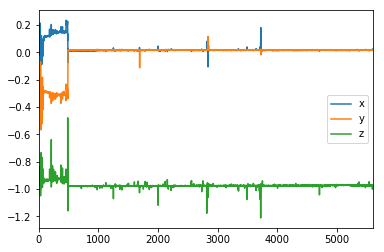

In [70]:
df1 = pd.read_json(os.path.join(path_acc_anx,'20191110161313_1383_accelerometer.json'))
df1.plot()

In [71]:
df1.describe()

,x,y,z
count,5607.000000,5607.000000,5607.000000
mean,0.024630,-0.013503,-0.971944
std,0.034380,0.091744,0.019312
min,-0.107260,-0.567905,-1.211466
25%,0.014365,0.013408,-0.977792
50%,0.015323,0.014365,-0.975877
75%,0.016281,0.015323,-0.973961
max,0.233674,0.114922,-0.479798


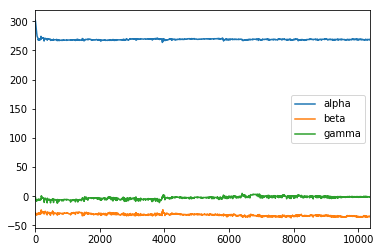

In [67]:
df2 = pd.read_json(os.path.join(path_dev_anx,'20191115103948_3262_device_motion.json'))
df2.plot()

In [68]:
df2.describe()

,alpha,beta,gamma
count,10363.000000,10363.000000,10363.000000
mean,268.977416,-31.968347,-2.478283
std,1.843690,2.090930,2.533679
min,263.776180,-37.303173,-11.708159
25%,268.354770,-33.703176,-4.306361
50%,268.881160,-31.829987,-2.120526
75%,269.368695,-30.532398,-0.648430
max,301.829000,-23.515232,4.791869


In [ ]:
pd_acc = pd_acc[pd_acc['std_z']>0.02]
pd_dev = pd_dev[pd_dev['std_x']>3]

# data reduction

In [ ]:
# 各特征与预测值相关性系数排序
cor_dev = pd_acc.corr()
cor_dev['ill'].apply(lambda x: abs(x)).sort_values(ascending = False)

In [ ]:
pd_dev = pd_dev.drop(['max_z','std_z','min_x'],axis=1)
pd_acc = pd_acc.drop(['max_x','min_x','std_z','min_y'],axis=1)
pd_gyr = pd_gyr.drop(['std_z','min_z','max_z'],axis=1)

# data transformation

都是数值型，不需要类别转换
根据模型是否使用梯度下降算法，后期考虑是否归一化